In [1]:
import numpy as np
import scipy.misc
import keras.backend as K
import tensorflow as tf
import sys
import cv2

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils, plot_model
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.initializers import glorot_normal
from matplotlib.pyplot import imshow
from keras.backend.tensorflow_backend import set_session
from keras.applications.resnet50 import ResNet50
from blocks import *
from res_model import *
from data_generator import DataGenerator
from dataset_utils import *

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

In [7]:
def get_resnet50(weights_type, freeze_net, dims, classes):
    X_input = Input((dims[0],dims[1],3))

    model = ResNet50(include_top=False,weights=weights_type,input_tensor = X_input,input_shape=(dims[0],dims[1],3))

    if freeze_net:
        for layer in model.layers[:48]:
            layer.trainable=False

    # Do surgery on dense head
    X = Flatten()(model.layers[-1].output)
    X = Dropout(0.4, name='fc_do')(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_normal(seed=0))(X)
    re_model = Model(input=X_input,output=X)

    return re_model

In [8]:
model = get_resnet50('imagenet', False, (200,200), 24)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fc...)`
  


In [5]:
class_to_id = get_class_to_id()
X_train, X_val = get_train_val()
Y_train, Y_val = get_labels(class_to_id, X_train, X_val)

params = {'dim': (200, 200),
          'batch_size': 16,
          'n_classes': 24,
          'n_channels': 3,
          'shuffle': True}

train_generator = DataGenerator(X_train, Y_train, **params)
val_generator = DataGenerator(X_val, Y_val, **params)

In [6]:

model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy', 'top_k_categorical_accuracy'])

lr_reducer = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=0.000001)
checkpoint_saver = ModelCheckpoint('resnet50.h5', verbose=True)
tensorboard_logger = TensorBoard('logs',
                                 histogram_freq=0,
                                 write_graph=False,
                                 write_grads=False,
                                 batch_size=16,
                                 write_images=False)

callback_list = [lr_reducer, checkpoint_saver, tensorboard_logger]

# Normalize image vectors

# Convert training and test labels to one hot matrices
print("number of training examples = " + str(len(X_train)))
print("number of test examples = " + str(len(X_val)))
print("X_train shape: " + str(len(X_train)))
print("Y_train shape: " + str(len(Y_train)))
print("X_test shape: " + str(len(X_val)))
print("Y_test shape: " + str(len(Y_val)))

model.summary()

hist = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    callbacks=callback_list,
    use_multiprocessing=True,
    workers=3, epochs=50, verbose=True)

number of training examples = 52992
number of test examples = 12782
X_train shape: 52992
Y_train shape: 52992
X_test shape: 12782
Y_test shape: 12782
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 200, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 100, 100, 64) 256  

Epoch 1/50
3312/3312 [==============================] - 738s 223ms/step - loss: 0.2009 - acc: 0.9404 - top_k_categorical_accuracy: 0.9908 - val_loss: 13.5038 - val_acc: 0.0426 - val_top_k_categorical_accuracy: 0.2115

Epoch 00001: saving model to resnet50.h5
Epoch 2/50
3312/3312 [==============================] - 735s 222ms/step - loss: 0.0421 - acc: 0.9878 - top_k_categorical_accuracy: 0.9995 - val_loss: 3.6136 - val_acc: 0.0427 - val_top_k_categorical_accuracy: 0.2091

Epoch 00002: saving model to resnet50.h5
Epoch 3/50
3312/3312 [==============================] - 736s 222ms/step - loss: 0.0283 - acc: 0.9920 - top_k_categorical_accuracy: 0.9998 - val_loss: 10.1991 - val_acc: 0.0427 - val_top_k_categorical_accuracy: 0.2101

Epoch 00003: saving model to resnet50.h5
Epoch 4/50
3312/3312 [==============================] - 736s 222ms/step - loss: 0.0206 - acc: 0.9942 - top_k_categorical_accuracy: 0.9999 - val_loss: 8.4168 - val_acc: 0.0426 - val_top_k_categorical_accuracy: 0.2110

Epoch 0

Process ForkPoolWorker-68:
Process ForkPoolWorker-69:
Process ForkPoolWorker-67:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.5/multiprocessing/pool.py", line 108, in worker
    task = g

KeyboardInterrupt: 

In [ ]:
model = load_model('resnet50.h5')
preds = model.evaluate_generator(
    val_generator, workers=6, use_multiprocessing=True)
print("Loss = " + str(preds[0]))
print("Test Accuracy = " + str(preds[1]))
with open('history.txt','w') as f:
    f.write(str(hist))
    f.write("\n")
    f.write("Loss = " + str(preds[0]) + ", Test Accuracy = " + str(preds[1]))

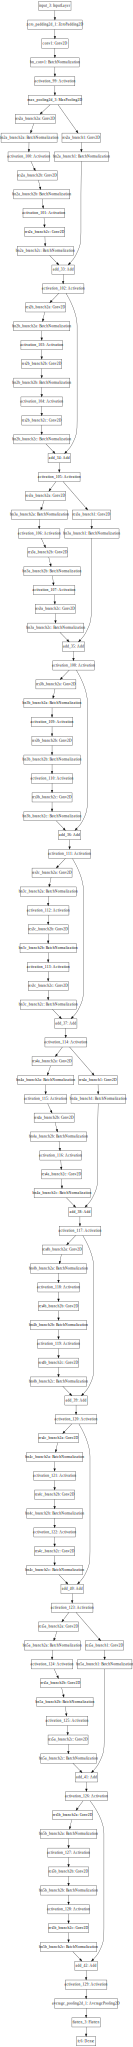

In [10]:
model = ResNet32()
plot_model(model, to_file='model_resnet32.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))